In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import periodogram
from math import isnan

In [3]:
def insertMissingDays(df):
    start = datetime(2000, 3, 1)
    end = datetime(2017, 9, 1)
    step = timedelta(days=1)

    while start <= end:
        if start.weekday() < 5: # 5 - Saturday, 6 - Sunday
            if not (start in df.index):
                df.loc[start] = df[:start].iloc[-1]
                df.loc[start, 'Holiday'] = 1
                df.sort_index(inplace = True)
            else:
                df.loc[start, 'Holiday'] = 0
        start += step
    
    return df

In [4]:
def acquireData(path, assetType, asset, samplingFrequency, replicateForHolidays = False):
    filepath = path + '/' + assetType + '/' + asset + '/' + samplingFrequency + '/' + asset + '.CSV'
    
    df = pd.read_csv(filepath, delimiter=';', decimal=',',
                     parse_dates=['Date'], dayfirst=True, index_col='Date')
    df = df.sort_index() #csv entries begin from most recent to older dates
    
    if replicateForHolidays:
        df.loc[:,'Holiday'] = 0
        df = insertMissingDays(df)
    
    df['Close_r'] = np.log(df.Close/df.Close.shift(1))
    
    return df

In [5]:
def plot_returnSeries(df, asset, initialDate = '', finalDate = ''):
    initialDate = initialDate if initialDate else df.index[0].strftime('%Y-%m-%d')
    finalDate = finalDate if finalDate else df.index[-1].strftime('%Y-%m-%d')
    title = asset + ' (' + initialDate + ')' if initialDate == finalDate else asset + ' (' + initialDate + ' to ' + finalDate + ')'
    
    fig, ax = plt.subplots(figsize=(10,10), nrows = 2, ncols = 1, sharex = True)

    plot_data = df[initialDate:finalDate]
    plt.xlabel('Date')
    ax[0].set_title(title)
    ax[0].set_ylabel('Price')
    ax[0].plot(plot_data['Close'])
    ax[0].grid()

    ax[1].set_ylabel('Returns')
    ax[1].plot(plot_data['Close_r'])
    ax[1].grid()

In [6]:
def plot_periodogram(df, column, initialLag = 0, numberOfLags = 30, yLog = False):
    if isnan(df[column].iloc[0]):
        df = df.drop(df.index[0])
    pgram = periodogram(df[column])
    length = len(pgram) if len(pgram) < numberOfLags else numberOfLags + 1

    fig, ax = plt.subplots(figsize=(10,10), nrows = 1, ncols = 1, sharex = True)
    plot_data = pgram[initialLag:length]
    plt.xlabel('Lags')
    ax.set_title('Periodogram')
    if yLog:
        plt.yscale('log')
    ax.stem(range(initialLag, length), plot_data)

In [7]:
def plot_seasonalDecompose(title, df, column, initialDate = '', finalDate = '', frequency = 1):
    initialDate = initialDate if initialDate else df.index[0].strftime('%Y-%m-%d')
    finalDate = finalDate if finalDate else df.index[-1].strftime('%Y-%m-%d')
    
    result = seasonal_decompose(df[column][initialDate:finalDate].values, model='additive', freq=frequency, two_sided=False)

    fig, ax = plt.subplots(figsize=(10,15), nrows = 4, ncols = 1)

    plot_data = df[initialDate:finalDate]
    plt.xlabel('Date')
    ax[0].set_title(title)
    ax[0].plot(df[initialDate:finalDate].index,plot_data[column],'b-')
    #ax[0].plot(df[initialDate:finalDate].index,plot_data['Open'],'r:')
    #ax[0].plot(df[initialDate:finalDate].index,plot_data['High'],'g:')
    #ax[0].plot(df[initialDate:finalDate].index,plot_data['Low'],'g:')
    ax[0].grid()

    ax[1].set_title('trend')
    ax[1].plot(df[initialDate:finalDate].index,result.trend)
    ax[1].grid()

    ax[2].set_title('seasonal')
    ax[2].plot(df[initialDate:finalDate].index,result.seasonal)
    ax[2].grid()

    ax[3].set_title('resid')
    ax[3].plot(df[initialDate:finalDate].index,result.resid)
    ax[3].grid()

In [11]:
dataPath = '/home/danilofrp/projeto_final/data'
assetType = 'stocks'
asset = 'PETR4'
frequency = 'diario'

df = acquireData(dataPath, assetType, asset, frequency, replicateForHolidays = True)

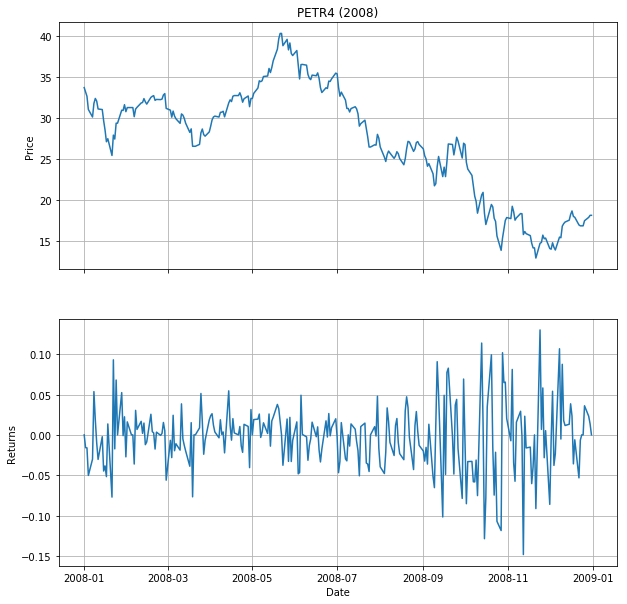

In [49]:
%matplotlib inline

plot_returnSeries(df, asset, '2008', '2008')

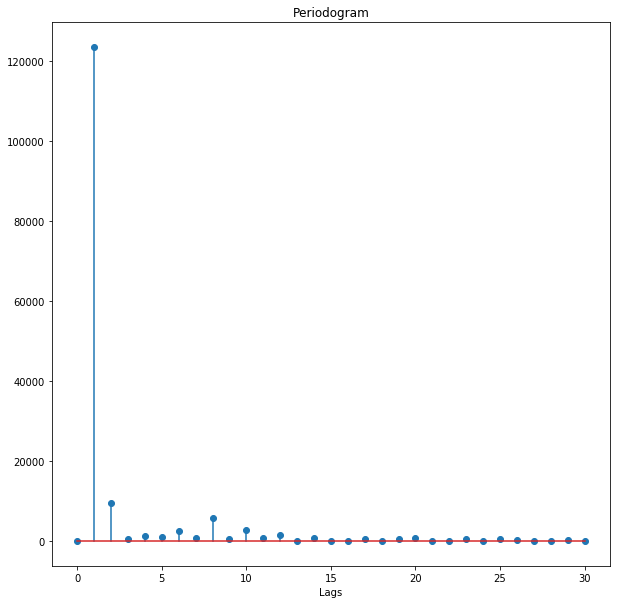

In [63]:
%matplotlib inline
plot_periodogram(df, 'Close', initialLag = 0, numberOfLags = 30, yLog = False)

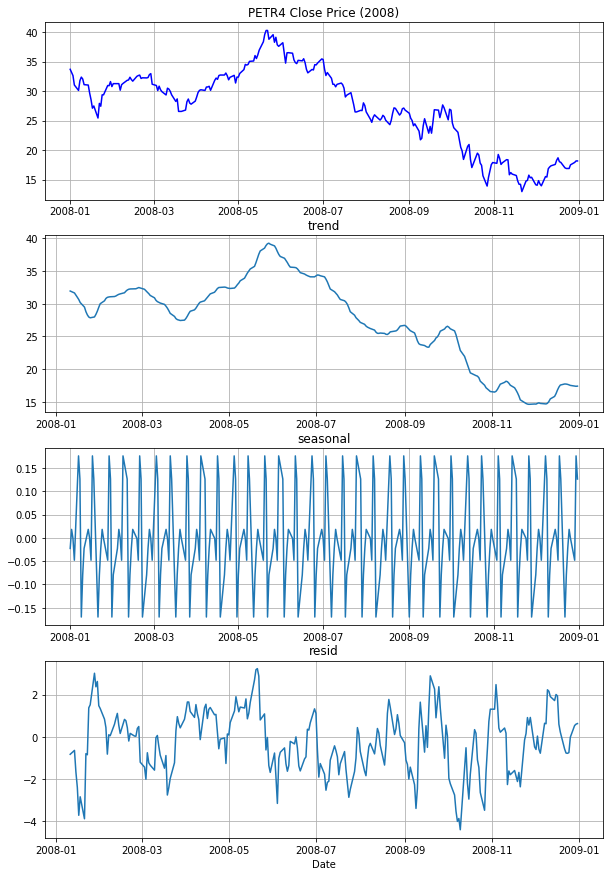

In [52]:
%matplotlib inline
#%matplotlib tk

plot_seasonalDecompose((asset + ' Close Price (2008)'), df, 'Close', initialDate='2008', finalDate='2008', frequency=8)